Import the required libraries

In [3]:
# Libraries
import os
import mne
from mne import EpochsArray, create_info
from mne import EvokedArray
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from collections import defaultdict

To save the figures that are not MNEQtBrowser

In [4]:
# Define a function to save all the Figures that are NOT MNEQtBrowser
def save_figure(fig, filename, folder="C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\Figures"):
    if not os.path.exists(folder):
        os.makedirs(folder)
    fig_path = os.path.join(folder, filename)
    fig.savefig(fig_path)
    print(f"Figure saved: {fig_path}")

# A. Data

## 1. Load the data

In [5]:
# Define the path to the .vhdr file
FolderPath = "C:\\Users\\indira.lavocat\\MOVIDOC\\EEG\\Sujets\\IndiraLAVOCAT" # need to adapt the last folder to suit the subject

# Looking for the .vhdr file in the folder
for file in os.listdir(FolderPath):
    if file.endswith(".vhdr"):
        FilePath = os.path.join(FolderPath, file)
        break

print(FilePath)


# vhdr_file = "C:\\Users\\indira.lavocat\\MOVIDOC\\EEG\\Indira Test\\MOVIDOCTicTrack000005.vhdr"

C:\Users\indira.lavocat\MOVIDOC\EEG\Sujets\IndiraLAVOCAT\MOVIDOCTicTrack000005.vhdr


In [6]:
raw = mne.io.read_raw_brainvision(FilePath, preload=True)

Extracting parameters from C:\Users\indira.lavocat\MOVIDOC\EEG\Sujets\IndiraLAVOCAT\MOVIDOCTicTrack000005.vhdr...
Setting channel info structure...


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\2402428994.py:1: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(FilePath, preload=True)


Reading 0 ... 79759  =      0.000 ...   159.518 secs...


In [7]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 31 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2025-05-13 16:30:12 UTC
 nchan: 31
 projs: []
 sfreq: 500.0 Hz
>

In [8]:
print(raw.ch_names)

['Fp1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']


In [9]:
print(raw.info['description']) # gives a note about the channels when there is one

None


## 2. Extract the events

In [10]:
# Create an events dicionnary
events, event_id = mne.events_from_annotations(raw)
print("Events list (stimulus) :")
print(event_id)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S  9'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25')]
Events list (stimulus) :
{np.str_('New Segment/'): 99999, np.str_('Stimulus/S  1'): 1, np.str_('Stimulus/S  2'): 2, np.str_('Stimulus/S  3'): 3, np.str_('Stimulus/S  4'): 4, np.str_('Stimulus/S  5'): 5, np.str_('Stimulus/S  6'): 6, np.str_('Stimulus/S  7'): 7, np.str_('Stimulus/S  8'): 8, np.str_('Stimulus/S  9'): 9, np.str_('Stimulus/S 10'): 10, np.str_('Stimulus/S 11'): 11, np.str_('Stimulus/S 12'): 12, np.str_('Stimulus/S 13'): 13, np.str_('S

In [11]:
# Display the tab of events
print("Events (sample, previous_id, event_id) :")
print(events)

Events (sample, previous_id, event_id) :
[[    0     0 99999]
 [ 2971     0     1]
 [ 6388     0    25]
 [ 6393     0     2]
 [10935     0    25]
 [10940     0     3]
 [12636     0    21]
 [13521     0    21]
 [14309     0    21]
 [15058     0    21]
 [15773     0    21]
 [15777     0     4]
 [19459     0    25]
 [19464     0     5]
 [24943     0     6]
 [28263     0    25]
 [28267     0     7]
 [33753     0     8]
 [36571     0    25]
 [36575     0     9]
 [38181     0    21]
 [38568     0    22]
 [40526     0    21]
 [41150     0    22]
 [42979     0    21]
 [43429     0    22]
 [44578     0    21]
 [45201     0    22]
 [46138     0    21]
 [46350     0    22]
 [47052     0    10]
 [51114     0    25]
 [51119     0    11]
 [51765     0    21]
 [52266     0    22]
 [54178     0    21]
 [54709     0    22]
 [55872     0    21]
 [56340     0    22]
 [57552     0    21]
 [58051     0    22]
 [59551     0    24]
 [60448     0    24]
 [61248     0    21]
 [61731     0    22]
 [61776     0 

In [12]:
# Convert the timestamps into seconds
events_no_zero = events[events[:, 0] != 0]  # <-- filters the events at 0.000 s
events_times_sec = events_no_zero[:, 0] / raw.info['sfreq'] # converts the timestamps into seconds

for time, eid in zip(events_times_sec, events_no_zero[:, 2]): # links each time in seconds to its event ID
    print(f"Stimulus {eid} à {time:.3f} s") # formats the number with 3 decimal

Stimulus 1 à 5.942 s
Stimulus 25 à 12.776 s
Stimulus 2 à 12.786 s
Stimulus 25 à 21.870 s
Stimulus 3 à 21.880 s
Stimulus 21 à 25.272 s
Stimulus 21 à 27.042 s
Stimulus 21 à 28.618 s
Stimulus 21 à 30.116 s
Stimulus 21 à 31.546 s
Stimulus 4 à 31.554 s
Stimulus 25 à 38.918 s
Stimulus 5 à 38.928 s
Stimulus 6 à 49.886 s
Stimulus 25 à 56.526 s
Stimulus 7 à 56.534 s
Stimulus 8 à 67.506 s
Stimulus 25 à 73.142 s
Stimulus 9 à 73.150 s
Stimulus 21 à 76.362 s
Stimulus 22 à 77.136 s
Stimulus 21 à 81.052 s
Stimulus 22 à 82.300 s
Stimulus 21 à 85.958 s
Stimulus 22 à 86.858 s
Stimulus 21 à 89.156 s
Stimulus 22 à 90.402 s
Stimulus 21 à 92.276 s
Stimulus 22 à 92.700 s
Stimulus 10 à 94.104 s
Stimulus 25 à 102.228 s
Stimulus 11 à 102.238 s
Stimulus 21 à 103.530 s
Stimulus 22 à 104.532 s
Stimulus 21 à 108.356 s
Stimulus 22 à 109.418 s
Stimulus 21 à 111.744 s
Stimulus 22 à 112.680 s
Stimulus 21 à 115.104 s
Stimulus 22 à 116.102 s
Stimulus 24 à 119.102 s
Stimulus 24 à 120.896 s
Stimulus 21 à 122.496 s
Stimulus

Alternative to display the stimulus name (and not its ID) with its timestamp in seconds

In [13]:
id_to_name = {v: k for k, v in event_id.items()}

for time, eid in zip(events_times_sec, events_no_zero[:, 2]):
    name = id_to_name.get(eid, f"ID {eid}")
    print(f"{name} à {time:.3f} s")

Stimulus/S  1 à 5.942 s
Stimulus/S 25 à 12.776 s
Stimulus/S  2 à 12.786 s
Stimulus/S 25 à 21.870 s
Stimulus/S  3 à 21.880 s
Stimulus/S 21 à 25.272 s
Stimulus/S 21 à 27.042 s
Stimulus/S 21 à 28.618 s
Stimulus/S 21 à 30.116 s
Stimulus/S 21 à 31.546 s
Stimulus/S  4 à 31.554 s
Stimulus/S 25 à 38.918 s
Stimulus/S  5 à 38.928 s
Stimulus/S  6 à 49.886 s
Stimulus/S 25 à 56.526 s
Stimulus/S  7 à 56.534 s
Stimulus/S  8 à 67.506 s
Stimulus/S 25 à 73.142 s
Stimulus/S  9 à 73.150 s
Stimulus/S 21 à 76.362 s
Stimulus/S 22 à 77.136 s
Stimulus/S 21 à 81.052 s
Stimulus/S 22 à 82.300 s
Stimulus/S 21 à 85.958 s
Stimulus/S 22 à 86.858 s
Stimulus/S 21 à 89.156 s
Stimulus/S 22 à 90.402 s
Stimulus/S 21 à 92.276 s
Stimulus/S 22 à 92.700 s
Stimulus/S 10 à 94.104 s
Stimulus/S 25 à 102.228 s
Stimulus/S 11 à 102.238 s
Stimulus/S 21 à 103.530 s
Stimulus/S 22 à 104.532 s
Stimulus/S 21 à 108.356 s
Stimulus/S 22 à 109.418 s
Stimulus/S 21 à 111.744 s
Stimulus/S 22 à 112.680 s
Stimulus/S 21 à 115.104 s
Stimulus/S 22 à 1

### NOT TO DO : Alternative whith a pandas DataFrame output

In [ ]:
id_to_name = {v: k for k, v in event_id.items()}

events_data = [] # création of dictionnaries list (one per event)
for time, eid in zip(events_times_sec, events[:, 2]):
    name = id_to_name.get(eid, f"ID {eid}")
    events_data.append({
        "Nom de l'événement": name,
        "ID": eid,
        "Temps (s)": round(time, 3)
    })

df_events = pd.DataFrame(events_data) # conversion into a DataFrame

print(df_events)

# B. Preprocessing

## 1. Define the montage

In [14]:
raw.set_montage("standard_1020") # to adapt according to the montage used during the exepriments

<RawBrainVision | MOVIDOCTicTrack000005.eeg, 31 x 79760 (159.5 s), ~18.9 MiB, data loaded>

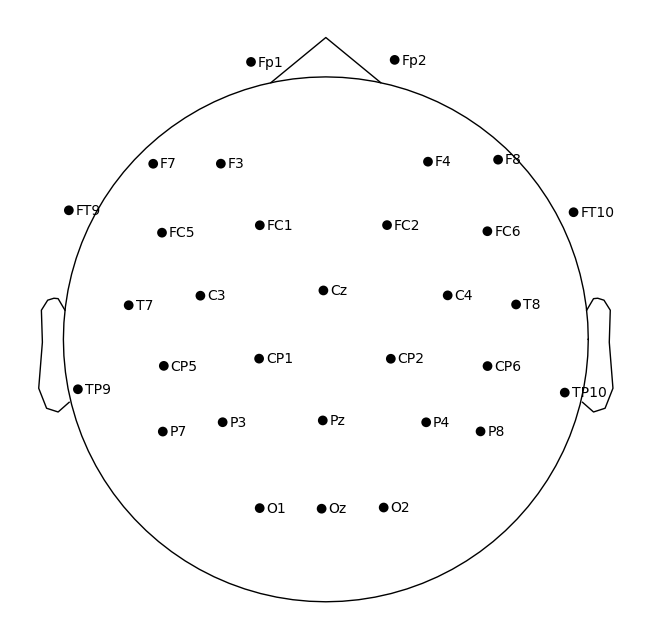

Figure saved: C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\Figures\Figure1_SensorsMontage.png


In [17]:
Sensors_Montage_Figure_1 = raw.plot_sensors(show_names=True)
save_figure(Sensors_Montage_Figure_1, "Figure1_SensorsMontage.png")
# fig.savefig("C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\Figures\\Figure1_SensorsMontage.png")

## 2. Filter the data with a band-pass

In [18]:
# Define the high and low frequencies
HFreq = 45
LFreq = 0.5
raw_HighLowPassed = raw.filter(l_freq = LFreq, h_freq = HFreq)

# for ERPs, [1-30] Hz band-pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.0s finished


In [19]:
# Plot the highpassed signal
Signal_HighLowPassed_Figure_2 = raw_HighLowPassed.plot(title = "High- and Low- passed Signal")

## 3. Filter the data with a Notch

In [20]:
# Define the parameters for the notch filter
if HFreq < 50:
    raw_Notched = raw_HighLowPassed
else:
    raw_Notched = raw_HighLowPassed.notch_filter(freqs = [50], picks = "data", method = "spectrum_fit")

In [21]:
# Plot the notched signal
Signal_Notched_Figure_3 = raw_Notched.plot(title = "Notched Signal")

## 4. Identify the bad channels => DONE DURING THE REST METHOD

## 5. Re-reference the data

In [22]:
# REST method : advanced EEG re-referencemen
print("Application du référentiel REST...")

# Create a spherical model of the head based on the file information 
Sphere = mne.make_sphere_model('auto', 'auto', raw_Notched.info)

# Define the volume source space
Source = mne.setup_volume_source_space(sphere=Sphere, exclude=30.0, pos=5.0, mri=None, verbose=False)

# Calculate the forward model solution
Forward = mne.make_forward_solution(raw_Notched.info, trans=None, src=Source, bem=Sphere, verbose=False)

# Apply the REST reference
raw_REST = raw_Notched.copy().set_eeg_reference('REST', forward=Forward)

Application du référentiel REST...
Fitted sphere radius:         96.0 mm
Origin head coordinates:      -0.9 13.5 42.7 mm
Origin device coordinates:    -0.9 13.5 42.7 mm

Equiv. model fitting -> RV = 0.00349057 %%
mu1 = 0.944702    lambda1 = 0.137194
mu2 = 0.667435    lambda2 = 0.683781
mu3 = -0.26548    lambda3 = -0.0106058
Set up EEG sphere model with scalp radius    96.0 mm

EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    31 out of 31 channels remain after picking


Optionnal : visualisation after REST

In [24]:
# Display the signal (after REST)
Signal_REST_Figure_4 = raw_REST.plot(title="Signal after REST")

Channels marked as bad:
none


## 7. Recalage

In [25]:
# Reset the file time
if events_times_sec[0] == 0 and len(events_times_sec) > 1: # check if the 1st stimulus is at 0 s. If so, use the 2nd stimulus
    first_stimulus_time = events_times_sec[1]
    print(f"First stimulus is at 0. Using second stimulus at {first_stimulus_time:.3f} s")
else:
    first_stimulus_time = events_times_sec[0]
    print(f"First stimulus at {first_stimulus_time:.3f} s")

First stimulus at 5.942 s


In [26]:
# Truncate the signal to start at this point
raw_cropped = raw_REST.copy().crop(tmin=first_stimulus_time)

In [27]:
# Reset the annotations by shifting all annotations by - first_stimulus_time
if raw.annotations is not None:
    raw_annotation_times = raw.annotations.onset - first_stimulus_time
    raw_cropped.set_annotations(
        mne.Annotations(
            onset=raw_annotation_times, # onset = raw_annotation_times with the new reset times
            duration=raw.annotations.duration,
            description=raw.annotations.description
        )
    )

C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\2637390326.py:4: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_cropped.set_annotations(


In [28]:
# Plot truncated and recalculated data
Readjusted_Signal_Figure_5 = raw_cropped.plot(title="Readjusted signal (from the 1st stimulus not at 0 s)")

# C. Epoching

## 1. Phase 1 (P1)
### Get the "press a key" baseline from the P1 phase

Get the stimuli in P1

In [29]:
# Define the parameters
begin_P1_stimulus = "Stimulus/S  3" # sent at the beginning of the P1 task
end_P1_stimulus = "Stimulus/S  4" # sent at the ending of the P1 task 

# Create a list with annotations and their times
list_annotations = list(zip(raw_cropped.annotations.onset, raw_cropped.annotations.description))

# Find all the segments in the P1 phase
P1_segments = []
i = 0
while i < len(list_annotations):
    onset, desc = list_annotations[i]
    if desc == begin_P1_stimulus:
        # Search the next end event
        for j in range(i + 1, len(list_annotations)):
            next_onset, next_desc = list_annotations[j]
            if next_desc == end_P1_stimulus:
                P1_segments.append((onset, next_onset))
                i = j  # continue after the stop
                break
    i += 1

# Get all the stimuli present in the segments
stimuli_in_P1 = []
for start, end in P1_segments:
    for onset, desc in list_annotations:
        if start <= onset <= end:
            # Do not take into account the beginning and ending stimuli
            if desc not in (begin_P1_stimulus, end_P1_stimulus):
                stimuli_in_P1.append((onset, desc))

# Display & check the stimuli found
print(f"{len(stimuli_in_P1)} stimuli trouvés entre '{begin_P1_stimulus}' et '{end_P1_stimulus}' :")
for onset, desc in stimuli_in_P1:
    print(f"{desc} à {onset:.3f} s")

5 stimuli trouvés entre 'Stimulus/S  3' et 'Stimulus/S  4' :
Stimulus/S 21 à 25.272 s
Stimulus/S 21 à 27.042 s
Stimulus/S 21 à 28.618 s
Stimulus/S 21 à 30.116 s
Stimulus/S 21 à 31.546 s


Get the the signal -1 second before & +1 second after each stimulus

In [30]:
# Define the window around each stimulus
tmin = -1.0 # 1 seconde before
tmax = 1.0 # 1 seconde after

# Get the sampling frequency
sfreq = raw_cropped.info['sfreq']

# Initiate a list to stock the extracted values (expected shape per segment : n_channels x n_times)
P1_signal_segments = []

for onset, desc in stimuli_in_P1:
    start = onset + tmin
    end = onset + tmax
    # Check if the window is not outside the signal bounds
    if start < 0 or end > raw_cropped.times[-1]:
        print(f"⚠️ Stimulus at {onset:.2f}s ignored (window [{start:.2f}, {end:.2f}] out of limits)")
        continue
    # Get the segment
    P1_segment = raw_cropped.copy().crop(tmin=start, tmax=end).get_data() # shape: (n_channels, n_times)
    P1_signal_segments.append(P1_segment)

# Convert into an array numpy : shape = (n_events, n_channels, n_times)
P1_segments_array = np.array(P1_signal_segments)

Create epochs for each segment

In [31]:
# Create an info object to build an EpochsArray object
info = create_info(
    ch_names=raw_cropped.ch_names,
    sfreq=sfreq,
    ch_types="eeg"  # to adapt according to the sensors nature
)

# Create the EpochsArray object from P1_segments_array
epochs_P1 = EpochsArray(P1_segments_array, info) # expected shape : (n_epochs, n_channels, n_times)

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


Save the epochs from P1 in a file

In [32]:
# Save into a .fif file
save_P1_path = "C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\.fif_files\\P1_epochs.fif"
epochs_P1.save(save_P1_path, overwrite=True)
print(f"✅ Segments sauvegardés dans : {save_P1_path}")

✅ Segments sauvegardés dans : C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P1_epochs.fif


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\4018977862.py:3: RuntimeWarning: This filename (C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_P1.save(save_P1_path, overwrite=True)


Get the mean of the epochs from P1

In [33]:
# Calculate the mean of the all the epochs : shape = (n_channels, n_times)
mean_segment = np.mean(P1_segments_array, axis=0)

# Create an Evoked object based on the mean
evoked_P1 = EvokedArray(mean_segment, info, tmin=tmin)

Save the Evoked mean of the epochs from P1

In [34]:
P1_evoked_save_path = "C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\.fif_files\\P1_average-epochs.fif"
evoked_P1.save(P1_evoked_save_path)
print(f"✅ Moyenne sauvegardée dans : {P1_evoked_save_path}")

✅ Moyenne sauvegardée dans : C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P1_average-epochs.fif


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\3798962205.py:2: RuntimeWarning: This filename (C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P1_average-epochs.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked_P1.save(P1_evoked_save_path)


#### OPTIONNAL : Display the mean segment

In [ ]:
# Calculate the mean over all the P1 events : shape = (n_channels, n_times)
mean_segment = np.mean(P1_segments_array, axis=0)

# Display the result shape
print(f"\n✅ {len(P1_signal_segments)} valide segments used.")
print(f"Shape of the mean segment : {mean_segment.shape} (n_channels, n_times)")


# Create the temporal axis for the mean segment
n_times = mean_segment.shape[1]
times = np.linspace(tmin, tmax, n_times)

# Trace each channel in a seperated figure
for ch_idx, ch_name in enumerate(raw_cropped.ch_names):
    signal = mean_segment[ch_idx, :]
    
    plt.figure(figsize=(8, 4))
    plt.plot(times, signal, label=f'Channel : {ch_name}')
    plt.title(f"Mean segment – Channel {ch_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### NO TO DO : Get the mean of the signal values at the exact time of each stimulus

In [ ]:
# Initiate a list to stock the extracted values
signal_values_at_stimulus = []

# Get the signal value for each stimulus
for onset, desc in stimuli_in_P1:
    sample_index = int(onset * raw_cropped.info['sfreq'])  # convertir le temps en index d'échantillon
    signal_sample = raw_cropped[:, sample_index][0]  # shape = (n_channels,)
    signal_values_at_stimulus.append(signal_sample)

# Convert into an array (shape: n_events x n_channels)
signal_values_array = np.array(signal_values_at_stimulus)  # shape = (n_events, n_channels)

# Mean of all the events (shape: n_channels,)
mean_signal_per_channel = np.mean(signal_values_array, axis=0)

# Display the mean signal from the stimuli in P1 phase
print("Mean value of the signal from the stimuli in P1 phase (per channel) :")
for ch_name, value in zip(raw_cropped.ch_names, mean_signal_per_channel):
    print(f"{ch_name}: {value:.3f} µV")

## 2. Phase 2 (P2)
### Get the "eyes closed" baseline from the P2 phase

In [35]:
# Define the parameters
begin_P2_stimulus = "Stimulus/S  5" # sent at the beginning of the P2a task
end_P2_stimulus = "Stimulus/S  6" # sent at the ending of the P2a task

# Search the stimuli times in the annotations
P2_onset_start = None
P2_onset_end = None

for onset, desc in zip(raw_cropped.annotations.onset, raw_cropped.annotations.description):
    if desc == begin_P2_stimulus and P2_onset_start is None:
        P2_onset_start = onset
    elif desc == end_P2_stimulus and P2_onset_start is not None:
        P2_onset_end = onset
        break # stopping the loop as soon as the pair of stimuli is found

# Check the segment found
if P2_onset_start is not None and P2_onset_end is not None:
    print(f"Segment detected : from {P2_onset_start:.2f} s to {P2_onset_end:.2f} s")

    window_length = 2.0 # window length in seconds
    step_size = 1.0 # step size for sliding window in seconds

    epochs_list = []
    times_list = []

    current_start = P2_onset_start
    while (current_start + window_length) <= P2_onset_end:
        current_end = current_start + window_length

        # Crop the raw signal for the current window
        window_segment = raw_cropped.copy().crop(tmin=current_start, tmax=current_end)
        data, times = window_segment.get_data(return_times=True)

        epochs_list.append(data) # shape (n_channels, n_times)
        times_list.append(times)

        print(f"Epoch from {current_start:.2f}s to {current_end:.2f}s extracted")

        # Move the window by step_size
        current_start += step_size
    
    # Convert the list of epochs into a numpy array with the shape (n_epochs, n_channels, n_times)
    epochs_array = np.array(epochs_list)

    # Create an info object for the epochs
    sfreq = raw_cropped.info['sfreq']
    info = mne.create_info(ch_names=raw_cropped.ch_names, sfreq=sfreq, ch_types='eeg')

    # Create the EpochsArray object
    epochs_P2 = mne.EpochsArray(epochs_array, info)

    print(f"\n✅ {len(epochs_list)} sliding epochs extracted between {P2_onset_start:.2f} and {P2_onset_end:.2f} seconds")

else:
    print("❌ Stimuli not found in the annotations.")

Segment detected : from 38.93 s to 49.89 s
Epoch from 38.93s to 40.93s extracted
Epoch from 39.93s to 41.93s extracted
Epoch from 40.93s to 42.93s extracted
Epoch from 41.93s to 43.93s extracted
Epoch from 42.93s to 44.93s extracted
Epoch from 43.93s to 45.93s extracted
Epoch from 44.93s to 46.93s extracted
Epoch from 45.93s to 47.93s extracted
Epoch from 46.93s to 48.93s extracted
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated

✅ 9 sliding epochs extracted between 38.93 and 49.89 seconds


Save the epochs from P2 in a file

In [36]:
save_path = "C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\.fif_files\\P2_sliding_epochs.fif"
epochs_P2.save(save_path, overwrite=True)
print(f"✅ Sliding epochs saved in: {save_path}")

✅ Sliding epochs saved in: C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P2_sliding_epochs.fif


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\2394468070.py:2: RuntimeWarning: This filename (C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P2_sliding_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_P2.save(save_path, overwrite=True)


Get the mean of the epochs from P2

<Evoked | '1' (average, N=9), 0 – 2 s, baseline off, 31 ch, ~276 KiB>


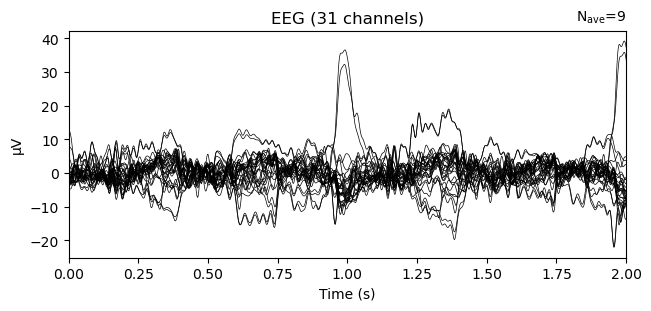

Text(0.5, 0.98, 'Average of sliding epochs from P2')

In [ ]:
# Calculate the mean of the epochs
evoked_P2 = epochs_P2.average()
print(evoked_P2)

# Plot the mean
Evoked_P2_Figure_6 = evoked_P2.plot() # does no take 'title' argument here
Evoked_P2_Figure_6.suptitle("Average of sliding epochs from P2", fontsize=14)
# evoked_P2.plot(title="Average of sliding epochs (P2)")

Save the Evoked mean of the epochs from P2

In [39]:
P2_evoked_save_path = "C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\.fif_files\\P2_average-epochs.fif"
evoked_P2.save(P2_evoked_save_path)
print(f"✅ Average evoked saved in: {P2_evoked_save_path}")

✅ Average evoked saved in: C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P2_average-epochs.fif


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\2779823942.py:2: RuntimeWarning: This filename (C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P2_average-epochs.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked_P2.save(P2_evoked_save_path)


## 3. Phase 3 (P3)
### Get the "eyes open" baseline from the P3 phase

In [40]:
# Define the parameters
begin_P3_stimulus = "Stimulus/S  5" # sent at the beginning of the P2a task
end_P3_stimulus = "Stimulus/S  6" # sent at the ending of the P2a task

# Search the stimuli times in the annotations
P3_onset_start = None
P3_onset_end = None

for onset, desc in zip(raw_cropped.annotations.onset, raw_cropped.annotations.description):
    if desc == begin_P3_stimulus and P3_onset_start is None:
        P3_onset_start = onset
    elif desc == end_P3_stimulus and P3_onset_start is not None:
        P3_onset_end = onset
        break # stopping the loop as soon as the pair of stimuli is found

# Check the segment found
if P3_onset_start is not None and P3_onset_end is not None:
    print(f"Segment detected : from {P3_onset_start:.2f} s to {P3_onset_end:.2f} s")

    window_length = 2.0 # window length in seconds
    step_size = 1.0 # step size for sliding window in seconds

    epochs_list = []
    times_list = []

    current_start = P3_onset_start
    while (current_start + window_length) <= P3_onset_end:
        current_end = current_start + window_length

        # Crop the raw signal for the current window
        window_segment = raw_cropped.copy().crop(tmin=current_start, tmax=current_end)
        data, times = window_segment.get_data(return_times=True)

        epochs_list.append(data) # shape (n_channels, n_times)
        times_list.append(times)

        print(f"Epoch from {current_start:.2f}s to {current_end:.2f}s extracted")

        # Move the window by step_size
        current_start += step_size
    
    # Convert the list of epochs into a numpy array with the shape (n_epochs, n_channels, n_times)
    epochs_array = np.array(epochs_list)

    # Create an info object for the epochs
    sfreq = raw_cropped.info['sfreq']
    info = mne.create_info(ch_names=raw_cropped.ch_names, sfreq=sfreq, ch_types='eeg')

    # Create the EpochsArray object
    epochs_P3 = mne.EpochsArray(epochs_array, info)

    print(f"\n✅ {len(epochs_list)} sliding epochs extracted between {P3_onset_start:.2f} and {P3_onset_end:.2f} seconds")

else:
    print("❌ Stimuli not found in the annotations.")

Segment detected : from 38.93 s to 49.89 s
Epoch from 38.93s to 40.93s extracted
Epoch from 39.93s to 41.93s extracted
Epoch from 40.93s to 42.93s extracted
Epoch from 41.93s to 43.93s extracted
Epoch from 42.93s to 44.93s extracted
Epoch from 43.93s to 45.93s extracted
Epoch from 44.93s to 46.93s extracted
Epoch from 45.93s to 47.93s extracted
Epoch from 46.93s to 48.93s extracted
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated

✅ 9 sliding epochs extracted between 38.93 and 49.89 seconds


Save the epochs from P3 in a file

In [41]:
save_path = "C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\.fif_files\\P3_sliding_epochs.fif"
epochs_P3.save(save_path, overwrite=True)
print(f"✅ Sliding epochs saved in: {save_path}")

✅ Sliding epochs saved in: C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P3_sliding_epochs.fif


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\207237715.py:2: RuntimeWarning: This filename (C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P3_sliding_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_P3.save(save_path, overwrite=True)


Get the mean of the epochs from P3

<Evoked | '1' (average, N=9), 0 – 2 s, baseline off, 31 ch, ~276 KiB>


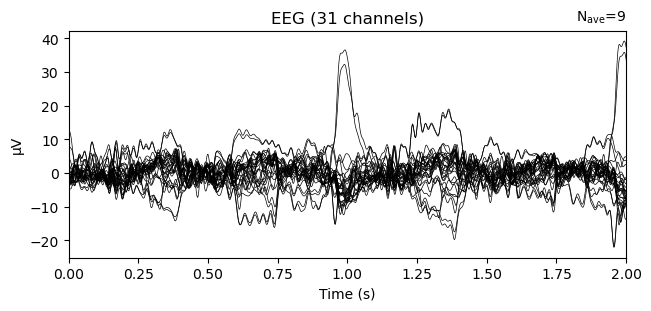

Text(0.5, 0.98, 'Average of sliding epochs from P3')

In [42]:
# Calculate the mean of the epochs
evoked_P3 = epochs_P2.average()
print(evoked_P3)

# Plot the mean
Evoked_P3_Figure_7 = evoked_P2.plot() # does no take 'title' argument here
Evoked_P3_Figure_7.suptitle("Average of sliding epochs from P3", fontsize=14)
# evoked_P3.plot(title="Average of sliding epochs (P3)")

Save the Evoked mean of the epochs from P3

In [43]:
P3_evoked_save_path = "C:\\Users\\indira.lavocat\\MOVIDOC\\tictrack_eeg_analysis\\.fif_files\\P3_average-epochs.fif"
evoked_P3.save(P3_evoked_save_path)
print(f"✅ Average evoked saved in: {P3_evoked_save_path}")

✅ Average evoked saved in: C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P3_average-epochs.fif


C:\Users\indira.lavocat\AppData\Local\Temp\ipykernel_22608\4058846807.py:2: RuntimeWarning: This filename (C:\Users\indira.lavocat\MOVIDOC\tictrack_eeg_analysis\.fif_files\P3_average-epochs.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked_P3.save(P3_evoked_save_path)


## 4. Phase 4 (P4)
### Get the spontaneous TICs

# * Topography *

In [ ]:
# evoked.plot_topomap(times=[0.1, 0.2, 0.3], ch_type='eeg', title="Topomap à 100/200/300 ms")
evoked.plot_topomap(times=[0.1, 0.2, 0.3], ch_type='eeg')

*** Show the Data ***

In [ ]:
plt.show()